In [1]:
## running once
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from toolz.curried import *
import matplotlib.pyplot as plt
import seaborn as sns

## Loading dataset

In [3]:
from util import *

In [4]:
year, month = 2021, 6
carpark_dir = "/home_nfs/jiangyue/data/carparking"
month_dir = os.path.join(carpark_dir, f"{year}/{month:02}")
carpark_meta = load_carpark_meta(os.path.join(carpark_dir, "carpark_meta_three_weeks.geojson"))

In [5]:
#carpark_meta

#carpark_meta[carpark_meta.Agency == "HDB"]

#carpark_meta[carpark_meta.Agency == "URA"]

#carpark_meta[carpark_meta.Agency == "LTA"].head()

In [6]:
%%time
carpark_data_names = [
    "carpark_data_2021_06_01-21.json",
    #"carpark_data_2021_04_21-25.json",
    #"carpark_data_2021_04_26-30.json"
]

carpark_data = load_carpark_data_list(
    [os.path.join(carpark_dir, name) for name in carpark_data_names]
)

Loading /home_nfs/jiangyue/data/carparking/carpark_data_2021_06_01-21.json
CPU times: user 12min 37s, sys: 1min 14s, total: 13min 52s
Wall time: 13min 51s


In [7]:
carpark_data_o = carpark_data.copy()
carpark_data_o.reset_index(inplace=True)
carpark_data_o.rename(columns={"tid": "date"}, inplace=True)

carpark_data = carpark_remove_outlier(carpark_data)
carpark_data = carpark_data.fillna(method="ffill")

100%|██████████| 1918/1918 [18:09<00:00,  1.76it/s]


In [8]:
carpark_data = carpark_add_date(carpark_data)
carpark_data = carpark_remove_constant(carpark_data)
carpark_data["min"] = (carpark_data.tid % 1440 // 5).astype(str)
len(carpark_data.sid.unique())

1843

In [9]:
#constant_sids = np.setdiff1d(carpark_meta.sid, carpark_data.sid.unique())
#carpark_meta[carpark_meta.sid.isin(constant_sids)]

## Visualization

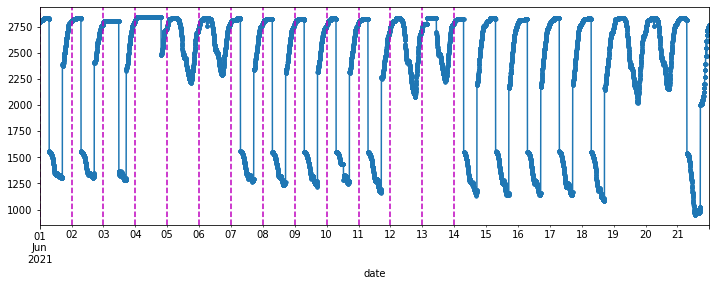

In [10]:
xs = pd.date_range("2021-06-01", periods=14)
ts = carpark_data[carpark_data.sid == 0].set_index("date")["AvailableLots"]
ts.plot(figsize=(12, 4), style=".-")
for x in xs:
    plt.axvline(x=x, linestyle='--', color="m")

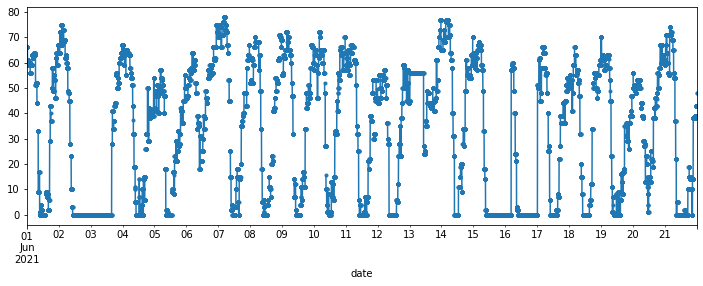

In [11]:
xs = pd.date_range("2021-04-26", periods=13)
ts = carpark_data_o[carpark_data_o.sid == 53].set_index("date")["AvailableLots"]
ts.plot(figsize=(12, 4), style=".-")
for x in xs:
    plt.axvline(x=x, linestyle='--', color="m")

In [12]:
# ts = carpark_data_o[carpark_data_o.sid == 45].set_index("date")["AvailableLots"]
# xs = ts[ts.diff().abs() > 100].index
# ts[sorted(np.concatenate([xs, xs - np.timedelta64(1, "m")]))]

# carpark_meta[carpark_meta.sid == 45]

## Forecasting

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
from torch.utils.data import DataLoader

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE
from dataloader import subset_sampler

In [15]:
carpark_data['Weekday']=carpark_data['date'].dt.dayofweek.astype(str)

In [16]:
context_length = 12*60
prediction_length = 2*60

training_cutoff = 17*24*60
validation_cutoff = 19*24*60
test_cutoff = 21*24*60

training = TimeSeriesDataSet(
    carpark_data[lambda x: x.tid <= training_cutoff],
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    time_varying_known_categoricals=["min", "Weekday"],
)

validation = TimeSeriesDataSet.from_dataset(
    training,                                         
    carpark_data[lambda x: x.tid <= validation_cutoff],
    min_prediction_idx=training_cutoff + 1
)

test = TimeSeriesDataSet.from_dataset(
    training, 
    carpark_data,
    min_prediction_idx=validation_cutoff + 1
)

In [17]:
train_sampler = subset_sampler(training, 0.5, random=True)
val_sampler = subset_sampler(validation, 0.05)
test_sampler = subset_sampler(test, 0.05)

In [18]:
batch_size = 200
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
                                          num_workers=8)                                          
val_dataloader = validation.to_dataloader(batch_size=500, num_workers=8,
                                          shuffle=False, sampler=val_sampler)                                          
test_dataloader = test.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_sampler)                                                                       

In [19]:
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

217861
508
508


In [20]:
# x_trn, y_trn = first(train_dataloader)
# x_val, y_val = first(val_dataloader)
# x_tst, y_tst = first(test_dataloader)

# x_trn["encoder_cat"].shape

# x_trn["decoder_cont"].shape

# x_trn["decoder_target"]

# rnn.output_transformer(dict(prediction=x_trn["decoder_cont"],
#                             target_scale=x_trn["target_scale"])).squeeze()
# training.target_normalizer(dict(prediction=x_trn["decoder_cont"],
#                                 target_scale=x_trn["target_scale"])).squeeze()

In [21]:
#training.index

In [22]:
# from pytorch_forecasting import Baseline

# baseline_predictions = Baseline().predict(test_dataloader)

# abs_error = torch.abs(baseline_predictions - actuals)

# print(torch.mean(abs_error * mask))
# errors = torch.mean(abs_error * mask, dim=0)

# mape = abs_error / (actuals + 1e-5)

# print(torch.mean(mape * mask))
# mapes = torch.mean(mape * mask, dim=0)

# plt.plot(torch.arange(1, len(errors)+1), errors, ".-")
# plt.xlabel("Time steps")
# plt.ylabel("MAE")

# plt.plot(torch.arange(1, len(mapes)+1), mapes, ".-")
# plt.xlabel("Time steps")
# plt.ylabel("MAPE")

In [23]:
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0

### LSTM

In [64]:
from models import RNN

In [65]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, 
                                    patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=500
)

rnn = RNN.from_dataset(
    training,
    embedding_sizes={"min": (1440 // 5, 91), "Weekday": (7, 20)},
    # embedding_sizes={"min": (1440 // 5, 91)},
    cell_type="GRU",
    hidden_size=50,
    learning_rate=1e-3,
    log_interval=50,
    log_val_interval=50,
    weight_decay=1e-3,
)

#rnn

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [66]:
print(rnn.lagged_target_positions)

{}


In [67]:
trainer.fit(
    rnn,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 26.3 K
3 | rnn              | GRU            | 39.9 K
4 | output_projector | Linear         | 51    
----------------------------------------------------
66.3 K    Trainable params
0         Non-trainable params
66.3 K    Total params
0.265     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [68]:
rnn.hparams

"categorical_groups":                {}
"cell_type":                         GRU
"dropout":                           0.1
"embedding_labels":                  {'min': {'0': 0, '1': 1, '10': 2, '100': 3, '101': 4, '102': 5, '103': 6, '104': 7, '105': 8, '106': 9, '107': 10, '108': 11, '109': 12, '11': 13, '110': 14, '111': 15, '112': 16, '113': 17, '114': 18, '115': 19, '116': 20, '117': 21, '118': 22, '119': 23, '12': 24, '120': 25, '121': 26, '122': 27, '123': 28, '124': 29, '125': 30, '126': 31, '127': 32, '128': 33, '129': 34, '13': 35, '130': 36, '131': 37, '132': 38, '133': 39, '134': 40, '135': 41, '136': 42, '137': 43, '138': 44, '139': 45, '14': 46, '140': 47, '141': 48, '142': 49, '143': 50, '144': 51, '145': 52, '146': 53, '147': 54, '148': 55, '149': 56, '15': 57, '150': 58, '151': 59, '152': 60, '153': 61, '154': 62, '155': 63, '156': 64, '157': 65, '158': 66, '159': 67, '16': 68, '160': 69, '161': 70, '162': 71, '163': 72, '164': 73, '165': 74, '166': 75, '167': 76, '168':

In [69]:
device = torch.device("cuda:0")
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RNN.load_from_checkpoint(best_model_path).to(device)
print(best_model_path)
print(best_model.device)

/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_34/checkpoints/epoch=3-step=1999.ckpt
cuda:0


In [70]:
%%time
predictions = best_model.predict(test_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)

Predict:   0%|          | 0/508 [00:00<?, ? batches/s]

torch.Size([254000, 120])
CPU times: user 53.5 s, sys: 5.93 s, total: 59.4 s
Wall time: 57.2 s


In [71]:
abs_error = torch.abs(predictions - actuals)

In [72]:
abs_error.shape

torch.Size([254000, 120])

In [73]:
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)

tensor(7.4335)


In [74]:
abs_error_steps.shape

torch.Size([120])

In [75]:
mape = abs_error / (actuals + 1e-5)

In [76]:
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)

tensor(0.1072)


Text(0, 0.5, 'MAE')

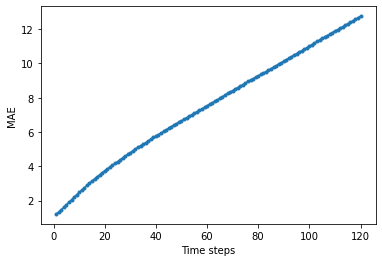

In [77]:
plt.plot(torch.arange(1, len(abs_error_steps)+1), abs_error_steps, ".-")
plt.xlabel("Time steps")
plt.ylabel("MAE")
#plt.xlim([1, 120])
#plt.xticks([1, 20, 40, 60, 80, 100, 120]);

In [78]:
abs_error_steps

tensor([ 1.2240,  1.3267,  1.4660,  1.6128,  1.7629,  1.9097,  2.0534,  2.1988,
         2.3379,  2.4755,  2.6140,  2.7515,  2.8815,  3.0087,  3.1429,  3.2668,
         3.3858,  3.5061,  3.6275,  3.7452,  3.8522,  3.9586,  4.0633,  4.1679,
         4.2714,  4.3793,  4.4880,  4.5922,  4.6945,  4.7996,  4.8991,  5.0026,
         5.1081,  5.2044,  5.2950,  5.3811,  5.4819,  5.5820,  5.6798,  5.7637,
         5.8534,  5.9416,  6.0370,  6.1279,  6.2200,  6.3131,  6.4032,  6.4864,
         6.5716,  6.6575,  6.7435,  6.8310,  6.9175,  7.0074,  7.0906,  7.1762,
         7.2658,  7.3543,  7.4417,  7.5324,  7.6202,  7.7018,  7.7865,  7.8706,
         7.9591,  8.0537,  8.1559,  8.2489,  8.3330,  8.4170,  8.5033,  8.5922,
         8.6822,  8.7657,  8.8554,  8.9446,  9.0315,  9.1118,  9.1943,  9.2716,
         9.3531,  9.4334,  9.5191,  9.6105,  9.6952,  9.7834,  9.8683,  9.9560,
        10.0420, 10.1314, 10.2215, 10.3009, 10.3881, 10.4838, 10.5741, 10.6576,
        10.7381, 10.8243, 10.9144, 11.00

Text(0, 0.5, 'MAPE')

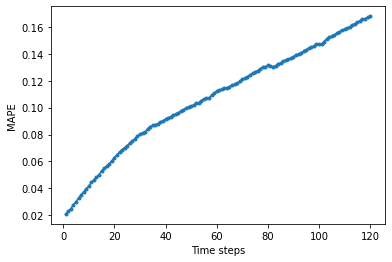

In [79]:
plt.plot(torch.arange(1, len(mape_steps)+1), mape_steps, ".-")
plt.xlabel("Time steps")
plt.ylabel("MAPE")
#plt.xlim([1, 120])
#plt.xticks([1, 20, 40, 60, 80, 100, 120]);

In [80]:
n = abs_error.shape[0]

In [81]:
step = 30 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()

μ = 4.7996, σ = 10.1719, max = 1286.4146


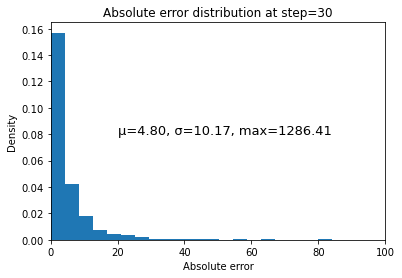

In [82]:
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

In [83]:
# raw_predictions, x = best_model.predict(test_dataloader, mode="raw", return_x=True, 
#                                         fast_dev_run=True)

# for idx in range(5, 10):
#     best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);